In [26]:
cd "/home/enesk/repos/spatial-prediction"

/home/enesk/repos/spatial-prediction


In [27]:
%load_ext autoreload
%autoreload 2
from data_set import Dataset
from predictor import Predictor, models
from predictor_utils import PiecewiseSchedule, OptimizerSpec
import tensorflow as tf
import datetime
from utils import get_session, plot_grid, plot_confusion_matrix
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import rc
import matplotlib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
os.environ['CUDA_VISIBLE_DEVICES'] = '' # We don't need a GPU to test the model

In [29]:
# Collect all parameters used when training this model
session_name = 'test3'
session_name = 'rand_walk_3'
session_name =  "rand_walk_interpol_new_dataset"
session_name = 'interpol_3_uav_3'

# Get the config file
config_file = "/home/enesk/repos/spatial-prediction/logs/config-%s.config" % session_name
config = pd.read_csv(config_file, sep = '\t').to_dict(orient = 'records')
meas_rate = ([float(record['value']) for record in config if record['parameter'] == 'measured_rate'][0])
model_name = ([str(record['value']) for record in config if record['parameter'] == 'model'][0])
regression = ([str(record['value']) for record in config if record['parameter'] == 'regression'][0]) == 'True'
no_maps = ([str(record['value']) for record in config if record['parameter'] == 'no_maps'][0]) == 'True'
random_walk = ([str(record['value']) for record in config if record['parameter'] == 'random_walk'][0]) == 'True'
cont_meas_rate = ([str(record['value']) for record in config if record['parameter'] == 'cont_meas_rate'][0]) == 'True'
mc_dropout = ([str(record['value']) for record in config if record['parameter'] == 'mc_dropout'][0]) == 'True' 
probabilistic = ([str(record['value']) for record in config if record['parameter'] == 'probabilistic'][0]) == 'True'
n_uavs = ([int(record['value']) for record in config if record['parameter'] == 'n_uavs'][0])
try:
    dataset_dir = ([str(record['value']) for record in config if record['parameter'] == 'dataset_dir'][0])
except:
    dataset_dir = "new_stored_grids"
plot = True
benchmark = False
kriging = False
model_scale = ([float(record['value']) for record in config if record['parameter'] == 'model_scale'][0])
if cont_meas_rate:
    meas_rate = 0.01
test_ds_prefix = "test_2"
train_ds_prefix = "train_2"
variable_rw_momentum = False
print("n_uavs", n_uavs)
print("meas_rate", meas_rate)

n_uavs 3
meas_rate 0.01


In [30]:
ds = Dataset(data_dir=dataset_dir,n_uavs = n_uavs, measured_rate = meas_rate, no_maps = no_maps, test_file_pfx=test_ds_prefix, train_file_pfx=train_ds_prefix, variable_rw_momentum = variable_rw_momentum)

There are 2307 training grids.
There are 418 testing grids.


In [31]:
predictor = Predictor(
        ds = ds, 
        session_name = session_name,
        regression = regression,
        model_name = model_name,
        probabilistic = probabilistic,
        use_tensor_rt=False,
        mc_dropout = mc_dropout, 
        random_walk = random_walk,
        model_scale = model_scale,
        )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Unet Layers Shapes:
(None, 96, 96, 2)
(TensorShape([None, 96, 96, 16]), TensorShape([None, 48, 48, 16]))
(TensorShape([None, 48, 48, 32]), TensorShape([None, 24, 24, 32]))
(TensorShape([None, 24, 24, 64]), TensorShape([None, 12, 12, 64]))
(TensorShape([None, 12, 12, 128]), TensorShape([None, 6, 6, 128]))
(None, 4608)
(None, 6, 6, 128) reshape_layer_output_shape
[None, 12, 12, 128]
[None, 24, 24, 64]
[None, 48, 48, 32]
[None, 96, 96, 16]
(None, 96, 96, 1)
Unet Layers Shapes:
(None, 96, 96, 2)
(TensorShape([None, 96, 96, 16]), TensorShape([None, 48, 48, 16]))
(TensorShape([None, 48, 48, 32]), TensorShape([None, 24, 24, 32]))
(TensorShape([None, 24, 24, 64]), TensorShape([None, 12, 12, 64]))
(TensorShape([None, 12, 12, 128]), TensorShape([None, 6, 6, 128]))
(None, 4608)
(None, 6, 6, 128) reshape_layer_output_shape
[None, 12, 12, 128]
[None, 24, 24, 64]
(None, 96, 96, 1)


In [32]:
predictor.restore("./models/%s/" % session_name)

In [33]:
n_samples = 1000

if n_samples > 1:
    plot = False
    
if benchmark or kriging:
    obs, labels, outdoors, non_scaled_maps, reconstruct_means, reconstruct_probs = ds.sample_whole_maps(n_samples, train = False, 
                                    include_non_scaled  = True, kriging = kriging, random_walk = random_walk, include_reconstruct = benchmark)
else:
    obs, labels, outdoors, non_scaled_maps = ds.sample_whole_maps(n_samples, train = False, 
                                    include_non_scaled  = True, include_reconstruct = benchmark, random_walk = random_walk, boolean=False)		


In [34]:
predictions = predictor.forward_pass(obs)
variance = predictor.get_variance(obs)

In [35]:
obs = np.asarray(obs)
labels = np.asarray(labels)
predictions = np.asarray(predictions).copy()
variance = np.asarray(variance).copy()
non_scaled_pwr_maps = np.asarray([map[0] for map in non_scaled_maps]).reshape(predictions.shape)
outdoors = np.asarray(outdoors, dtype=np.int32)
if regression or probabilistic or mc_dropout:
    raw_value_pred = ds.scaled_to_raw(predictions)
    raw_value_labels = ds.scaled_to_raw(labels)
    coverage_pred = (raw_value_pred >= ds.PWR_THRESHOLD)
    hard_loss = np.mean(((raw_value_labels >= ds.PWR_THRESHOLD) == coverage_pred).reshape(n_samples, -1), axis = -1)
    soft_loss = np.sum((np.abs(raw_value_pred - non_scaled_pwr_maps) * outdoors)) / np.sum(outdoors) 
    raw_value_pred[outdoors == 0] = -250
    predictions[outdoors == 0] = None
    variance[outdoors == 0] = None
    raw_value_variance = ds.scale_var_to_raw(variance)
    raw_value_variance[outdoors == 0] = None

print(np.mean(hard_loss), np.mean(soft_loss))
			

0.9357494574652778 15.451564573973021


/home/enesk/repos/spatial-prediction/utils.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.arange(grid.shape[0], step = step) * spacing)


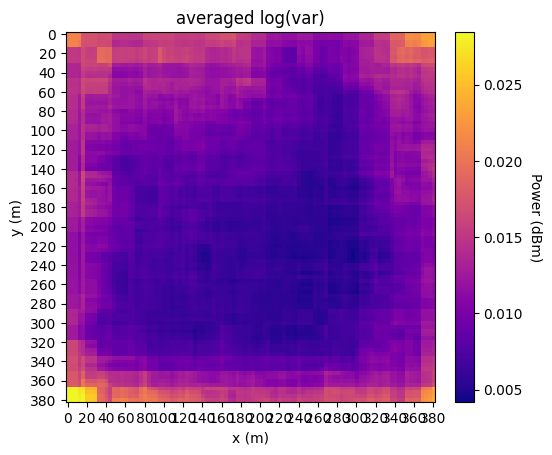

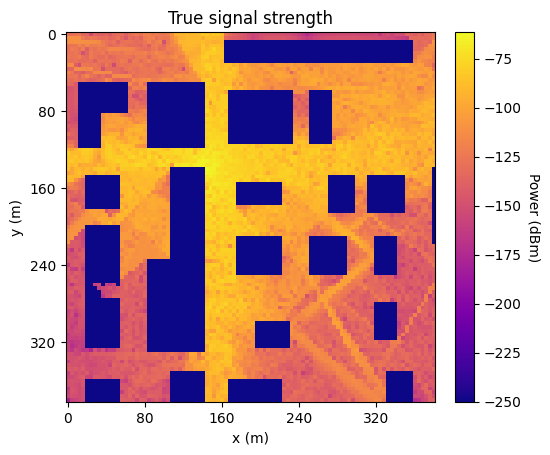

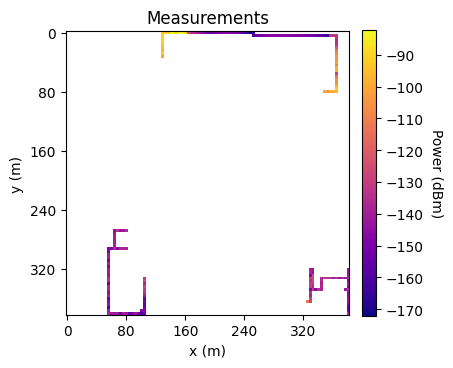

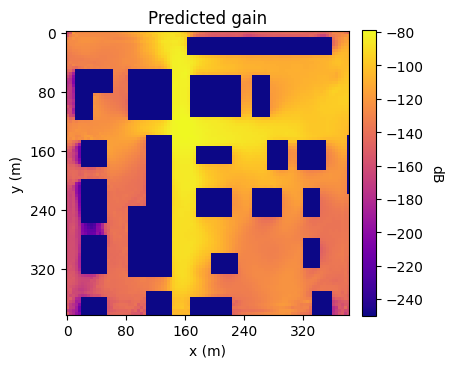

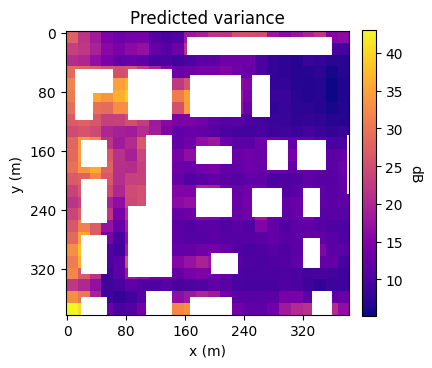

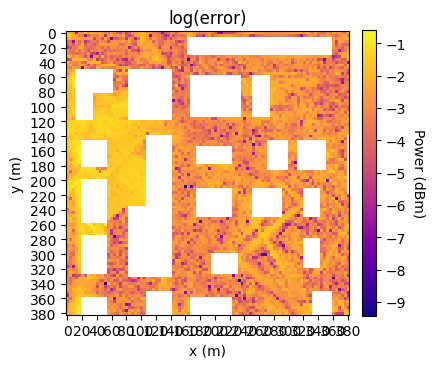

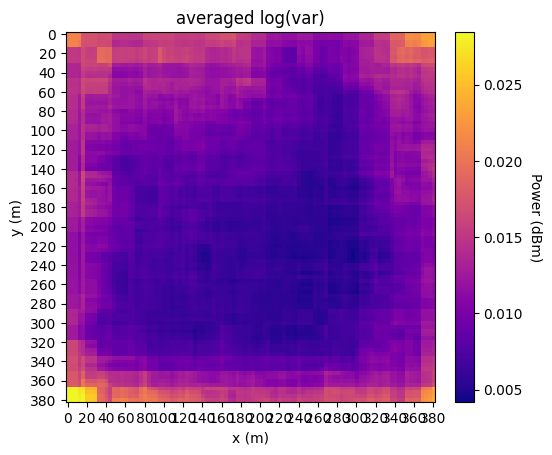

In [36]:
#plot_grid(obs[i][:, :, 0], title = 'Buildings')
for i in [9]:
    plot_grid(non_scaled_maps[i][0], title = 'True signal strength', cbartitle = 'Power (dBm)', spacing=4, step = 20)
    fig = plot_grid(non_scaled_maps[i][1], title = 'City map', cbartitle = 'Height (m)', spacing=4, step = 20)
    fig.set_size_inches(4, 4)
    fig = plot_grid(non_scaled_maps[i][2], title = 'Measurements', cbartitle = 'Power (dBm)', spacing=4, step = 20)
    fig.set_size_inches(4, 4)

    #plot_grid(labels[i].reshape(non_scaled_maps[i][0].shape), title = 'True signal strength', cbartitle = 'Power (dBm)')
    #plot_grid(outdoors[i].reshape(non_scaled_maps[i][0].shape), title = 'Outdoors')

    if regression or probabilistic or mc_dropout:
        fig = plot_grid(raw_value_pred[i, :, :], title = 'Predicted gain', cbartitle = 'dB', spacing=4, step = 20)
        fig.set_size_inches(4, 4)
        fig = plot_grid(np.sqrt((raw_value_variance[i, :, :])), title = 'Predicted variance', cbartitle = 'dB', spacing=4, step = 20)
        fig.set_size_inches(4, 4)
        fig = plot_grid(np.log10(np.square(labels - predictions)[i, :, :]), title = 'log(error)', cbartitle = 'Power (dBm)')
        fig.set_size_inches(4, 4)

# Average variance
variance_cp = np.copy(variance)
variance_cp[outdoors == 0] = 0
variance_cp = np.sum(variance_cp,axis=0) / np.sum(outdoors==1, axis = 0)
plot_grid(((variance_cp)), title = 'averaged log(var)', cbartitle = 'Power (dBm)')

[ 0  1  2  3  4  5  6  7  8  9 10 11]


[Text(1, 0, '0.12'),
 Text(2, 0, '0.21'),
 Text(3, 0, '0.29'),
 Text(4, 0, '0.38'),
 Text(5, 0, '0.46'),
 Text(6, 0, '0.54'),
 Text(7, 0, '0.62'),
 Text(8, 0, '0.71'),
 Text(9, 0, '0.79'),
 Text(10, 0, '0.87'),
 Text(11, 0, '0.96')]

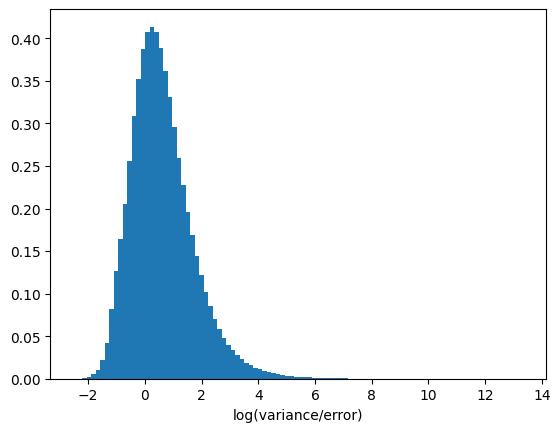

In [37]:
# Plot error vs variance
fig, ax = plt.subplots()
ax.hist(np.log10(variance /  np.square(labels - predictions)).flatten(), density=True, bins = 100)
ax.set_xlabel("log(variance/error)")

# Plot variance/error vs power as boxplot
n_bins = 12
lower_bounds = np.linspace(0, 1-1/n_bins, n_bins)
upper_bounds = lower_bounds + 1/n_bins
bin_centers = lower_bounds + 1/n_bins/2
var_over_error = np.log10(raw_value_variance / np.square(raw_value_pred - non_scaled_pwr_maps)).flatten()
error = (np.square(labels - predictions)).flatten()
power_bins = (labels.reshape((-1, 1)) > lower_bounds) & (labels.reshape((-1, 1)) < upper_bounds)
power_bins = np.argmax(power_bins, axis = -1)
print(np.unique(power_bins))

boxplot_data = []
boxplot_data_error = []
mean_data = []
for i in range(0, n_bins):
    boxplot_data.append(var_over_error[(power_bins == i) & (~np.isnan(var_over_error))])
    boxplot_data_error.append(error[(power_bins == i) & (~np.isnan(error))])
    mean_data.append(np.mean(var_over_error[(power_bins == i) & (~np.isnan(var_over_error))]))



fig, ax = plt.subplots()
fig.set_size_inches(7,5)
ax.boxplot(boxplot_data[1:], sym = "")
ax.set_xlabel("CG")
fig.tight_layout()
ax.set_ylabel(r"$\rho_{k,j}$")
ax.set_xticklabels(["%.2f" % ds.scaled_to_raw(b) for b in bin_centers[1:]])

fig, ax = plt.subplots()
fig.set_size_inches(8, 4.5)
ax.boxplot(boxplot_data_error[1:], sym = "")
ax.set_xlabel("power")
ax.set_ylabel("squared error")
ax.set_xticklabels(["%.2f" % b for b in bin_centers[1:]])